In this assignment you will learn how to apply the REINFORCE algorithm within the OpenAI Gym environment. Make sure OpenAI gym is installed on your machine. Now let's import some relevant packages.

In [1]:
import gym
from gym import wrappers, logger
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from chainer import Chain
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import Adam
from chainer import Variable

%matplotlib inline

We will make use of the classic CartPole environment provided by OpenAI Gym. Figure out what the details of this environment are.

https://github.com/openai/gym/wiki/CartPole-v0

**Observation**

Type: Box(4)
Num 	Observation 	Min 	Max

0 	Cart Position 	-2.4 	2.4

1 	Cart Velocity 	-Inf 	Inf

2 	Pole Angle 	~ -41.8° 	~ 41.8°

3 	Pole Velocity At Tip 	-Inf 	Inf

[Cart Position, Cart Velocity, Pole Angle, Pole Velocity]

**Actions**

Type: Discrete(2)

Num 	Action

0 	Push cart to the left

1 	Push cart to the right

Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it.

**Reward**

Reward is 1 for every step taken, including the termination step

**Starting State**

All observations are assigned a uniform random value between ±0.05
Episode Termination

1. Pole Angle is more than ±12°
2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
3. Episode length is greater than 200

**Solved Requirements**

Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.

In [2]:
env_id = 'CartPole-v0'

# You can set the level to logger.DEBUG or logger.WARN if you want to change the amount of output. INFO
logger.set_level(logger.DEBUG)

In [3]:
### TEST
env = gym.make('CartPole-v0')
for i_episode in range(2):
    print('\n>> episode', i_episode)
    observation = env.reset()
    
    # actions inside each episode
    for t in range(20):
#         env.render()
        print('observation',observation, end=' ')
        action = env.action_space.sample()
        print('action', action, end=' ')
        observation, reward, done, info = env.step(action)
        print('reward', reward)
        if done:
            print("\nEpisode finished after {} timesteps".format(t+1))
            break

INFO: Making new env: CartPole-v0

>> episode 0
observation [0.0255545  0.0157826  0.02058901 0.00664761] action 0 reward 1.0
observation [ 0.02587015 -0.17962848  0.02072196  0.30575485] action 1 reward 1.0
observation [0.02227758 0.01519214 0.02683706 0.01967848] action 1 reward 1.0
observation [ 0.02258142  0.20991914  0.02723063 -0.2644177 ] action 0 reward 1.0
observation [0.02677981 0.01441932 0.02194228 0.03672813] action 1 reward 1.0
observation [ 0.02706819  0.20921986  0.02267684 -0.24895182] action 1 reward 1.0
observation [ 0.03125259  0.40401074  0.0176978  -0.53439661] action 1 reward 1.0
observation [ 0.03933281  0.5988794   0.00700987 -0.82145093] action 1 reward 1.0
observation [ 0.05131039  0.79390474 -0.00941915 -1.11192087] action 1 reward 1.0
observation [ 0.06718849  0.98914914 -0.03165757 -1.40754366] action 1 reward 1.0
observation [ 0.08697147  1.18464929 -0.05980844 -1.70995272] action 1 reward 1.0
observation [ 0.11066446  1.38040525 -0.09400749 -2.02063485] 

Let's define a baseline agent which just emits random actions.

In [4]:
class RandomAgent(object):
    """The world's simplest agent!"""

    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done):
        return self.action_space.sample()


Let's run the agent on the environment.

In [5]:
env = gym.make(env_id)
env.seed(0)
agent = RandomAgent(env.action_space)

episode_count = 1000
done = False
reward = 0
    
R0 = np.zeros(episode_count)

random_history = {}

for i in tqdm.trange(episode_count):

    ob = env.reset()
    temp_history = {'obs':[], 'act':[], 'reward':0}
    temp_history['obs'].append(ob)
    while True:

        action = agent.act(ob, reward, done)
        temp_history['act'].append(action)
        ob, reward, done, _ = env.step(action)
        temp_history['obs'].append(ob)
        R0[i] += reward
        
        if done:
            temp_history['reward'] = R0[i]
            random_history[i] = temp_history
            break

# Close the env and write monitor result info to disk
env.close()
print(max(R0))


 44%|████▎     | 435/1000 [00:00<00:00, 4345.87it/s]

INFO: Making new env: CartPole-v0


100%|██████████| 1000/1000 [00:00<00:00, 4250.31it/s]

92.0


In [6]:
# for eps in random_history:
#     print(eps, random_history[eps])
#     print('---')

0 {'obs': [array([-0.04456399,  0.04653909,  0.01326909, -0.02099827]), array([-0.04363321,  0.24146826,  0.01284913, -0.30946528]), array([-0.03880385,  0.04616562,  0.00665982, -0.01275795]), array([-0.03788053,  0.24119143,  0.00640466, -0.30333221]), array([-0.03305671,  0.04597879,  0.00033802, -0.0086363 ]), array([-3.21371306e-02,  2.41095889e-01,  1.65294467e-04, -3.01212554e-01]), array([-0.02731521,  0.43621548, -0.00585896, -0.59384335]), array([-0.0185909 ,  0.24117603, -0.01773582, -0.30301171]), array([-0.01376738,  0.4365462 , -0.02379606, -0.60123494]), array([-0.00503646,  0.63199281, -0.03582076, -0.90131722]), array([ 0.0076034 ,  0.43737402, -0.0538471 , -0.62010536]), array([ 0.01635088,  0.24304382, -0.06624921, -0.34485596]), array([ 0.02121175,  0.43904257, -0.07314633, -0.65767217]), array([ 0.02999261,  0.2450109 , -0.08629977, -0.38888877]), array([ 0.03489282,  0.44124499, -0.09407755, -0.70748512]), array([ 0.04371772,  0.63753558, -0.10822725, -1.02823703]

77 {'obs': [array([-0.02714999,  0.04988585, -0.03537134,  0.03918537]), array([-0.02615227,  0.24549671, -0.03458764, -0.26444438]), array([-0.02124234,  0.05088507, -0.03987652,  0.01713175]), array([-0.02022463, -0.14364299, -0.03953389,  0.29697128]), array([-0.02309749,  0.05201958, -0.03359446, -0.00791319]), array([-0.0220571 ,  0.24760681, -0.03375273, -0.31100341]), array([-0.01710497,  0.05298159, -0.03997279, -0.02915328]), array([-0.01604533, -0.14154501, -0.04055586,  0.25065466]), array([-0.01887623,  0.05413192, -0.03554277, -0.05453953]), array([-0.0177936 ,  0.249745  , -0.03663356, -0.3582212 ]), array([-0.0127987 ,  0.44536807, -0.04379798, -0.6622268 ]), array([-0.00389134,  0.64107116, -0.05704252, -0.96837241]), array([ 0.00893009,  0.44675956, -0.07640997, -0.69414049]), array([ 0.01786528,  0.25277601, -0.09029278, -0.42645685]), array([ 0.0229208 ,  0.05904122, -0.09882191, -0.16354849]), array([ 0.02410162, -0.13453739, -0.10209288,  0.09639637]), array([ 0.02

106 {'obs': [array([-0.01583403, -0.04344028, -0.00357584,  0.03503158]), array([-0.01670283,  0.15173277, -0.00287521, -0.25877741]), array([-0.01366818,  0.34689565, -0.00805076, -0.55236583]), array([-0.00673026,  0.15188768, -0.01909807, -0.26223026]), array([-0.00369251,  0.34727696, -0.02434268, -0.56087523]), array([ 0.00325303,  0.54273194, -0.03556018, -0.86112688]), array([ 0.01410767,  0.34811183, -0.05278272, -0.57983375]), array([ 0.02106991,  0.54393217, -0.0643794 , -0.8886661 ]), array([ 0.03194855,  0.34974021, -0.08215272, -0.61689607]), array([ 0.03894335,  0.54590793, -0.09449064, -0.934281  ]), array([ 0.04986151,  0.74216878, -0.11317626, -1.25509794]), array([ 0.06470489,  0.54866314, -0.13827822, -0.99989927]), array([ 0.07567815,  0.35563302, -0.1582762 , -0.75364222]), array([ 0.08279081,  0.55254189, -0.17334905, -1.09165278]), array([ 0.09384165,  0.74947119, -0.1951821 , -1.43332932]), array([ 0.10883107,  0.94639108, -0.22384869, -1.78012047])], 'act': [1,

174 {'obs': [array([-0.01936732,  0.01500068,  0.01202147, -0.01231877]), array([-0.0190673 , -0.18029159,  0.01177509,  0.2841327 ]), array([-0.02267314, -0.37557949,  0.01745775,  0.58050604]), array([-0.03018473, -0.18070647,  0.02906787,  0.29337336]), array([-0.03379886,  0.01398925,  0.03493534,  0.00999791]), array([-0.03351907, -0.18161585,  0.03513529,  0.31349543]), array([-0.03715139,  0.01298842,  0.0414052 ,  0.03209683]), array([-0.03689162,  0.20749289,  0.04204714, -0.24724017]), array([-0.03274176,  0.4019899 ,  0.03710234, -0.5263696 ]), array([-0.02470196,  0.59657067,  0.02657494, -0.80713431]), array([-0.01277055,  0.79131851,  0.01043226, -1.0913408 ]), array([ 0.00305582,  0.98630142, -0.01139456, -1.38073224]), array([ 0.02278185,  0.79132353, -0.0390092 , -1.09163431]), array([ 0.03860832,  0.98693726, -0.06084189, -1.39629747]), array([ 0.05834706,  1.18276099, -0.08876784, -1.70736605]), array([ 0.08200228,  0.98876485, -0.12291516, -1.44358106]), array([ 0.1

199 {'obs': [array([ 0.02619393,  0.04676518,  0.01513654, -0.00624252]), array([ 0.02712923, -0.14857055,  0.01501169,  0.29117748]), array([ 0.02415782, -0.34390329,  0.02083524,  0.58855686]), array([ 0.01727975, -0.14907921,  0.03260638,  0.30250928]), array([0.01429817, 0.04556322, 0.03865657, 0.0202854 ]), array([ 0.01520943,  0.24011009,  0.03906227, -0.25995469]), array([0.02001164, 0.04445291, 0.03386318, 0.04478859]), array([ 0.02090069, -0.15113785,  0.03475895,  0.3479604 ]), array([ 0.01787794, -0.3467365 ,  0.04171816,  0.65139823]), array([ 0.01094321, -0.15221965,  0.05474613,  0.3721384 ]), array([ 0.00789881, -0.34807487,  0.06218889,  0.68156841]), array([ 9.37315802e-04, -5.44002865e-01,  7.58202616e-02,  9.93164029e-01]), array([-0.00994274, -0.34997269,  0.09568354,  0.72522474]), array([-0.0169422 , -0.15629495,  0.11018804,  0.46412506]), array([-0.02006809, -0.35278743,  0.11947054,  0.78940609]), array([-0.02712384, -0.15949106,  0.13525866,  0.53656913]), arr

251 {'obs': [array([0.04050371, 0.02649694, 0.04404489, 0.00832361]), array([ 0.04103364,  0.22096046,  0.04421136, -0.27014376]), array([ 0.04545285,  0.41542453,  0.03880849, -0.54856093]), array([ 0.05376134,  0.60998043,  0.02783727, -0.82876821]), array([ 0.06596095,  0.80471097,  0.01126191, -1.11256776]), array([ 0.08205517,  0.99968322, -0.01098945, -1.40169665]), array([ 0.10204884,  0.80469952, -0.03902338, -1.11246959]), array([ 0.11814283,  1.00031166, -0.06127277, -1.41713439]), array([ 0.13814906,  0.80599959, -0.08961546, -1.14421617]), array([ 0.15426905,  0.61215528, -0.11249978, -0.88092818]), array([ 0.16651216,  0.41872654, -0.13011835, -0.6256244 ]), array([ 0.17488669,  0.61540176, -0.14263084, -0.9562903 ]), array([ 0.18719472,  0.42245616, -0.16175664, -0.71160224]), array([ 0.19564385,  0.22989967, -0.17598869, -0.47388732]), array([ 0.20024184,  0.42701329, -0.18546643, -0.8164648 ]), array([ 0.20878211,  0.62412414, -0.20179573, -1.16127558]), array([ 0.22126

276 {'obs': [array([-0.00820016,  0.0358919 ,  0.02439787,  0.02554759]), array([-0.00748232, -0.15957129,  0.02490882,  0.32582737]), array([-0.01067375, -0.35503887,  0.03142536,  0.62626023]), array([-0.01777453, -0.16036935,  0.04395057,  0.34363765]), array([-0.02098191,  0.03410069,  0.05082332,  0.06513159]), array([-0.0202999 , -0.1617117 ,  0.05212595,  0.37340654]), array([-0.02353413, -0.35753387,  0.05959409,  0.68205894]), array([-0.03068481, -0.16328795,  0.07323526,  0.40871759]), array([-0.03395057,  0.03072337,  0.08140962,  0.1399926 ]), array([-0.0333361 , -0.16546448,  0.08420947,  0.45720773]), array([-0.03664539,  0.0283723 ,  0.09335362,  0.19221119]), array([-0.03607795,  0.22204341,  0.09719785, -0.06962441]), array([-0.03163708,  0.02567204,  0.09580536,  0.25207353]), array([-0.03112364,  0.21930468,  0.10084683, -0.00891977]), array([-0.02673754,  0.0228919 ,  0.10066843,  0.31380126]), array([-0.02627971, -0.17350925,  0.10694446,  0.63645804]), array([-0.0

332 {'obs': [array([ 0.03551229, -0.03113072,  0.00868545,  0.00167997]), array([ 0.03488968, -0.22637615,  0.00871904,  0.29709056]), array([ 0.03036216, -0.4216213 ,  0.01466086,  0.59251052]), array([ 0.02192973, -0.61694539,  0.02651107,  0.8897753 ]), array([ 0.00959082, -0.81241684,  0.04430657,  1.19067279]), array([-0.00665751, -0.61789614,  0.06812003,  0.91219996]), array([-0.01901544, -0.81387032,  0.08636403,  1.22549125]), array([-0.03529284, -0.61995999,  0.11087385,  0.9610693 ]), array([-0.04769204, -0.81638337,  0.13009524,  1.28642541]), array([-0.06401971, -1.01289865,  0.15582375,  1.61684757]), array([-0.08427768, -1.2094771 ,  0.1881607 ,  1.95376964]), array([-0.10846723, -1.40603448,  0.22723609,  2.29839525])], 'act': [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], 'reward': 11.0}
---
333 {'obs': [array([ 0.03034419, -0.01516908, -0.04890024,  0.02409847]), array([ 0.03004081,  0.1806188 , -0.04841827, -0.28360322]), array([ 0.03365318, -0.01378033, -0.05409033, -0.00657568

363 {'obs': [array([ 0.03116091,  0.03487404,  0.01834535, -0.01511031]), array([ 0.03185839,  0.22972816,  0.01804314, -0.30194907]), array([ 0.03645295,  0.42458837,  0.01200416, -0.58888741]), array([ 4.49447179e-02,  6.19540184e-01,  2.26414433e-04, -8.77764921e-01]), array([ 0.05733552,  0.42441516, -0.01732888, -0.58501082]), array([ 0.06582382,  0.22954017, -0.0290291 , -0.29783667]), array([ 0.07041463,  0.42506365, -0.03498583, -0.59953167]), array([ 0.0789159 ,  0.62065716, -0.04697647, -0.90302614]), array([ 0.09132904,  0.81638289, -0.06503699, -1.21009686]), array([ 0.1076567 ,  0.62215822, -0.08923893, -0.93848318]), array([ 0.12009987,  0.8183626 , -0.10800859, -1.25782009]), array([ 0.13646712,  0.62477584, -0.13316499, -1.0008249 ]), array([ 0.14896264,  0.82140171, -0.15318149, -1.3321874 ]), array([ 0.16539067,  1.01808705, -0.17982524, -1.66862027]), array([ 0.18575241,  1.21478645, -0.21319764, -2.01149584])], 'act': [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1], 'rew

405 {'obs': [array([ 0.04681007,  0.04050387,  0.03649182, -0.04221423]), array([ 0.04762015, -0.15512185,  0.03564754,  0.26175521]), array([ 0.04451772, -0.35073404,  0.04088264,  0.56546524]), array([ 0.03750303, -0.15620878,  0.05219195,  0.28593731]), array([ 0.03437886, -0.35203472,  0.05791069,  0.59461371]), array([ 0.02733816, -0.15776909,  0.06980297,  0.32071998]), array([ 0.02418278, -0.35381209,  0.07621737,  0.63457378]), array([ 0.01710654, -0.54990978,  0.08890884,  0.95025258]), array([ 0.00610835, -0.35608979,  0.10791389,  0.68677569]), array([-0.00101345, -0.16261815,  0.12164941,  0.42992153]), array([-0.00426581,  0.03059003,  0.13024784,  0.17792779]), array([-0.00365401,  0.22363083,  0.13380639, -0.07099606]), array([ 0.0008186 ,  0.41660598,  0.13238647, -0.31864956]), array([ 0.00915072,  0.60961842,  0.12601348, -0.56682682]), array([ 0.02134309,  0.80276838,  0.11467694, -0.81730448]), array([ 0.03739846,  0.99614938,  0.09833085, -1.07182956]), array([ 0.0

437 {'obs': [array([-0.02715103,  0.04945118,  0.03945594, -0.01523052]), array([-0.026162  , -0.14621375,  0.03915133,  0.28963549]), array([-0.02908628, -0.34187148,  0.04494404,  0.59440473]), array([-0.03592371, -0.53759273,  0.05683214,  0.90089925]), array([-0.04667556, -0.34328498,  0.07485012,  0.62660784]), array([-0.05354126, -0.14928322,  0.08738228,  0.35840539]), array([-0.05652693, -0.34553169,  0.09455039,  0.67731265]), array([-0.06343756, -0.15184173,  0.10809664,  0.41583182]), array([-0.06647439,  0.04159547,  0.11641328,  0.15908815]), array([-0.06564248, -0.15498406,  0.11959504,  0.48610991]), array([-0.06874217,  0.03826525,  0.12931724,  0.23338368]), array([-0.06797686,  0.23132515,  0.13398491, -0.01587474]), array([-0.06335036,  0.42429654,  0.13366742, -0.26346374]), array([-0.05486443,  0.61728248,  0.12839814, -0.51117915]), array([-0.04251878,  0.81038417,  0.11817456, -0.76080192]), array([-0.02631109,  1.00369702,  0.10295852, -1.0140863 ]), array([-0.0

485 {'obs': [array([ 0.02712127,  0.04101089,  0.00427883, -0.0266675 ]), array([ 0.02794149, -0.15417216,  0.00374548,  0.26736237]), array([ 0.02485805,  0.04089614,  0.00909273, -0.02413686]), array([ 0.02567597, -0.15435503,  0.00860999,  0.271401  ]), array([ 0.02258887,  0.04064301,  0.01403801, -0.01855391]), array([ 0.02340173,  0.23556086,  0.01366693, -0.30677483]), array([ 0.02811295,  0.04024685,  0.00753144, -0.00981322]), array([ 0.02891788, -0.1549823 ,  0.00733517,  0.28523641]), array([ 0.02581824, -0.35020809,  0.0130399 ,  0.58022375]), array([ 0.01881408, -0.54551032,  0.02464438,  0.87698581]), array([ 0.00790387, -0.35073182,  0.04218409,  0.5921515 ]), array([ 0.00088923, -0.15622502,  0.05402712,  0.31304929]), array([-0.00223527, -0.35207334,  0.06028811,  0.62226938]), array([-0.00927673, -0.54798302,  0.0727335 ,  0.93331397]), array([-0.02023639, -0.35391373,  0.09139977,  0.66434449]), array([-0.02731467, -0.16017409,  0.10468666,  0.40178219]), array([-0.0

534 {'obs': [array([ 0.00662271, -0.04398567, -0.00149031,  0.03765837]), array([ 0.00574299,  0.15115762, -0.00073715, -0.2554944 ]), array([ 0.00876615, -0.0439538 , -0.00584703,  0.03695593]), array([ 0.00788707,  0.15125151, -0.00510792, -0.25756605]), array([ 0.0109121 , -0.04379715, -0.01025924,  0.0335014 ]), array([ 0.01003616, -0.23877049, -0.00958921,  0.32292986]), array([ 0.00526075, -0.04351331, -0.00313061,  0.02723837]), array([ 0.00439048,  0.15165339, -0.00258584, -0.26643065]), array([ 0.00742355, -0.04343156, -0.00791446,  0.02543556]), array([ 0.00655492, -0.23843912, -0.00740575,  0.31561092]), array([ 0.00178614, -0.04321246, -0.00109353,  0.0206017 ]), array([ 0.00092189, -0.23831872, -0.00068149,  0.3129394 ]), array([-0.00384449, -0.04318706,  0.0055773 ,  0.02004163]), array([-0.00470823, -0.23838855,  0.00597813,  0.31447903]), array([-0.009476  , -0.43359515,  0.01226771,  0.60904125]), array([-0.0181479 , -0.23864683,  0.02444853,  0.32024738]), array([-0.0

550 {'obs': [array([-0.0477521 , -0.02324186,  0.01281112, -0.03289151]), array([-0.04821694,  0.17169405,  0.01215329, -0.32150502]), array([-0.04478306, -0.02359884,  0.00572319, -0.02501433]), array([-0.04525503, -0.2188024 ,  0.0052229 ,  0.26946882]), array([-0.04963108, -0.02375537,  0.01061228, -0.02156221]), array([-0.05010619,  0.1712128 ,  0.01018103, -0.31087804]), array([-0.04668193,  0.36618823,  0.00396347, -0.60033286]), array([-0.03935817,  0.17101105, -0.00804318, -0.30640414]), array([-0.03593795, -0.02399537, -0.01417127, -0.01626864]), array([-0.03641785,  0.17132692, -0.01449664, -0.31338887]), array([-0.03299132,  0.36665235, -0.02076442, -0.61060809]), array([-0.02565827,  0.5620583 , -0.03297658, -0.90975812]), array([-0.0144171 ,  0.75761066, -0.05117174, -1.21262054]), array([ 7.35110531e-04,  9.53354358e-01, -7.54241523e-02, -1.52088968e+00]), array([ 0.0198022 ,  1.14930245, -0.10584195, -1.83612986]), array([ 0.04278825,  0.9554979 , -0.14256454, -1.5781093

600 {'obs': [array([ 0.00443624,  0.03273661, -0.01404552, -0.04149315]), array([ 0.00509097, -0.16218114, -0.01487538,  0.24672539]), array([ 0.00184735,  0.03315007, -0.00994088, -0.05061221]), array([ 0.00251035,  0.22841314, -0.01095312, -0.34641491]), array([ 0.00707861,  0.42368916, -0.01788142, -0.64253153]), array([ 0.0155524 ,  0.61905573, -0.03073205, -0.94079139]), array([ 0.02793351,  0.42436117, -0.04954788, -0.65792124]), array([ 0.03642074,  0.62013649, -0.0627063 , -0.96578495]), array([ 0.04882347,  0.81604207, -0.082022  , -1.27748934]), array([ 0.06514431,  1.01210832, -0.10757179, -1.59468742]), array([ 0.08538647,  0.81841423, -0.13946554, -1.33739084]), array([ 0.10175476,  0.62529708, -0.16621335, -1.09139781]), array([ 0.1142607 ,  0.82217251, -0.18804131, -1.43128308]), array([ 0.13070415,  0.62980249, -0.21666697, -1.20277354])], 'act': [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0], 'reward': 13.0}
---
601 {'obs': [array([-0.00781381, -0.00184408,  0.04214316, -0.02

629 {'obs': [array([0.00040696, 0.03170987, 0.01379993, 0.03103919]), array([ 0.00104116,  0.22663123,  0.01442072, -0.25725796]), array([ 0.00557378,  0.42154437,  0.00927556, -0.54535771]), array([ 0.01400467,  0.22629332, -0.0016316 , -0.24976677]), array([ 0.01853054,  0.42143853, -0.00662693, -0.54296389]), array([ 0.02695931,  0.61665299, -0.01748621, -0.83772744]), array([ 0.03929237,  0.81200932, -0.03424076, -1.13585783]), array([ 0.05553255,  0.61735165, -0.05695792, -0.85410729]), array([ 0.06787959,  0.81320174, -0.07404006, -1.16414259]), array([ 0.08414362,  0.61911766, -0.09732291, -0.89556197]), array([ 0.09652597,  0.42544044, -0.11523415, -0.63498869]), array([ 0.10503478,  0.23209832, -0.12793393, -0.38070282]), array([ 0.10967675,  0.42878277, -0.13554798, -0.71082848]), array([ 0.1182524 ,  0.6254955 , -0.14976455, -1.04292022]), array([ 0.13076231,  0.43264523, -0.17062296, -0.80074926]), array([ 0.13941522,  0.62964514, -0.18663794, -1.14187834]), array([ 0.15200

685 {'obs': [array([ 0.045513  , -0.04118619,  0.01953644, -0.04108666]), array([ 0.04468928,  0.15365025,  0.01871471, -0.32754219]), array([ 0.04776228,  0.34850083,  0.01216386, -0.61426508]), array([ 5.47322989e-02,  1.53211041e-01, -1.21438174e-04, -3.17775979e-01]), array([ 0.05779652,  0.34833472, -0.00647696, -0.6104972 ]), array([ 0.06476321,  0.1533039 , -0.0186869 , -0.31986132]), array([ 0.06782929,  0.34868693, -0.02508413, -0.61837832]), array([ 0.07480303,  0.15392418, -0.03745169, -0.33370006]), array([ 0.07788151, -0.04064527, -0.0441257 , -0.05305877]), array([ 0.07706861, -0.23510765, -0.04518687,  0.22538213]), array([ 0.07236646, -0.03937   , -0.04067923, -0.08120507]), array([ 0.07157906, -0.23388591, -0.04230333,  0.19837103]), array([ 0.06690134, -0.03818523, -0.03833591, -0.10735084]), array([ 0.06613763,  0.15746452, -0.04048293, -0.41187783]), array([ 0.06928692,  0.35313627, -0.04872048, -0.71704371]), array([ 0.07634965,  0.15872125, -0.06306136, -0.4400853

705 {'obs': [array([-0.02961723, -0.04367707,  0.001256  ,  0.00656854]), array([-0.03049077, -0.23881701,  0.00138737,  0.29964748]), array([-0.03526711, -0.04371486,  0.00738032,  0.00740243]), array([-0.03614141, -0.23894187,  0.00752837,  0.30240477]), array([-0.04092025, -0.43417031,  0.01357646,  0.59745244]), array([-0.04960365, -0.62947958,  0.02552551,  0.8943807 ]), array([-0.06219325, -0.82493821,  0.04341312,  1.19497682]), array([-0.07869201, -1.02059456,  0.06731266,  1.50094428]), array([-0.0991039 , -0.82635153,  0.09733155,  1.23001454]), array([-0.11563093, -0.63260709,  0.12193184,  0.96934368]), array([-0.12828307, -0.8291362 ,  0.14131871,  1.29770786]), array([-0.1448658 , -0.63606295,  0.16727287,  1.05239461]), array([-0.15758706, -0.4435061 ,  0.18832076,  0.81653997]), array([-0.16645718, -0.25139243,  0.20465156,  0.58850395]), array([-0.17148503, -0.05963504,  0.21642164,  0.36661874])], 'act': [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1], 'reward': 14.0}
---


---
764 {'obs': [array([-0.04090633, -0.0200093 , -0.01614813, -0.04090777]), array([-0.04130652,  0.17534044, -0.01696629, -0.33864153]), array([-0.03779971,  0.37069965, -0.02373912, -0.63662603]), array([-0.03038572,  0.17591667, -0.03647164, -0.35151252]), array([-0.02686738, -0.01866815, -0.04350189, -0.07054968]), array([-0.02724075, -0.21314031, -0.04491288,  0.20809706]), array([-0.03150355, -0.01740587, -0.04075094, -0.09840847]), array([-0.03185167,  0.17827571, -0.04271911, -0.40366462]), array([-0.02828616,  0.37397667, -0.0507924 , -0.70950384]), array([-0.02080662,  0.17959363, -0.06498248, -0.43323186]), array([-0.01721475,  0.37557254, -0.07364712, -0.74567118]), array([-0.0097033 ,  0.5716293 , -0.08856054, -1.06059182]), array([ 0.00172929,  0.76780537, -0.10977238, -1.3797055 ]), array([ 0.01708539,  0.57421165, -0.13736649, -1.12327107]), array([ 0.02856963,  0.38113139, -0.15983191, -0.87663775]), array([ 0.03619226,  0.18850052, -0.17736467, -0.6381651 ]), array([

782 {'obs': [array([-0.00309351, -0.01461844,  0.04077216,  0.02960736]), array([-0.00338587,  0.17989582,  0.04136431, -0.24993784]), array([ 0.00021204, -0.01579168,  0.03636555,  0.05549996]), array([-1.03791723e-04,  1.78790488e-01,  3.74755537e-02, -2.25491198e-01]), array([ 0.00347202,  0.37335736,  0.03296573, -0.50612136]), array([ 0.01093917,  0.17778676,  0.0228433 , -0.20323467]), array([ 0.0144949 ,  0.3725747 ,  0.01877861, -0.48862501]), array([ 0.02194639,  0.17719292,  0.00900611, -0.19008342]), array([ 0.02549025,  0.37218487,  0.00520444, -0.47991173]), array([ 0.03293395,  0.56723297, -0.00439379, -0.77094981]), array([ 0.04427861,  0.76241511, -0.01981279, -1.06501197]), array([ 0.05952691,  0.9577936 , -0.04111303, -1.36384676]), array([ 0.07868278,  0.76321007, -0.06838996, -1.08430193]), array([ 0.09394699,  0.95916443, -0.090076  , -1.39763734]), array([ 0.11313027,  0.7652707 , -0.11802875, -1.13442239]), array([ 0.12843569,  0.96172251, -0.1407172 , -1.4616698

845 {'obs': [array([-0.04488547, -0.00720805, -0.0050719 , -0.04964933]), array([-0.04502963, -0.20225691, -0.00606489,  0.24142906]), array([-0.04907477, -0.39729171, -0.0012363 ,  0.53219281]), array([-0.0570206 , -0.20215239,  0.00940755,  0.23912058]), array([-0.06106365, -0.39740746,  0.01418996,  0.53475601]), array([-0.0690118 , -0.2024879 ,  0.02488508,  0.24657781]), array([-0.07306156, -0.39795626,  0.02981664,  0.54700503]), array([-0.08102068, -0.20326563,  0.04075674,  0.26386368]), array([-0.08508599, -0.39894491,  0.04603401,  0.56911801]), array([-0.09306489, -0.20449781,  0.05741637,  0.29128557]), array([-0.09715485, -0.40038943,  0.06324209,  0.60150995]), array([-0.10516264, -0.20620649,  0.07527228,  0.32939861]), array([-0.10928677, -0.01223229,  0.08186026,  0.06137035]), array([-0.10953141, -0.20842671,  0.08308766,  0.37871655]), array([-0.11369995, -0.01457697,  0.09066199,  0.11334472]), array([-0.11399149, -0.21087316,  0.09292889,  0.43319785]), array([-0.1

865 {'obs': [array([ 0.03170968, -0.04953302,  0.02661642, -0.02862014]), array([ 0.03071901,  0.14519733,  0.02604401, -0.3127879 ]), array([ 0.03362296,  0.33993876,  0.01978826, -0.59714491]), array([ 0.04042174,  0.14454557,  0.00784536, -0.29829514]), array([ 0.04331265, -0.05068733,  0.00187945, -0.00314829]), array([ 0.0422989 , -0.24583618,  0.00181649,  0.29012703]), array([ 0.03738218, -0.05074018,  0.00761903, -0.00198244]), array([ 0.03636737,  0.14427168,  0.00757938, -0.29225176]), array([ 0.03925281, -0.05095752,  0.00173435,  0.00281193]), array([ 0.03823366, -0.2461043 ,  0.00179058,  0.29604156]), array([ 0.03331157, -0.05100792,  0.00771142,  0.00392389]), array([ 0.03229141, -0.24623961,  0.00778989,  0.29902986]), array([ 0.02736662, -0.05122956,  0.01377049,  0.00881386]), array([ 0.02634203, -0.24654626,  0.01394677,  0.30580954]), array([ 0.0214111 , -0.05162581,  0.02006296,  0.0175575 ]), array([ 0.02037859, -0.24702965,  0.02041411,  0.31650239]), array([ 0.0

928 {'obs': [array([ 0.00885737,  0.04487778,  0.03836011, -0.01468562]), array([ 0.00975493, -0.15077271,  0.0380664 ,  0.28984932]), array([0.00673947, 0.04378634, 0.04386339, 0.00941099]), array([ 0.0076152 , -0.15193633,  0.04405161,  0.31560431]), array([0.00457647, 0.04253136, 0.05036369, 0.03713275]), array([ 0.0054271 ,  0.23689627,  0.05110635, -0.23924427]), array([0.01016503, 0.0410829 , 0.04632146, 0.06911102]), array([ 0.01098668,  0.23551119,  0.04770368, -0.20860495]), array([ 0.01569691,  0.42991972,  0.04353159, -0.48586643]), array([ 0.0242953 ,  0.23421139,  0.03381426, -0.17978781]), array([0.02897953, 0.03862229, 0.0302185 , 0.12336764]), array([ 0.02975198,  0.23329857,  0.03268585, -0.15963058]), array([ 0.03441795,  0.42793769,  0.02949324, -0.4418254 ]), array([ 0.0429767 ,  0.62263014,  0.02065673, -0.72506731]), array([ 0.0554293 ,  0.81746044,  0.00615539, -1.01117776]), array([ 0.07177851,  1.01249972, -0.01406817, -1.30192146]), array([ 0.09202851,  0.8175

939 {'obs': [array([-0.01727943,  0.0186341 ,  0.02433741, -0.0477456 ]), array([-0.01690675, -0.17682822,  0.0233825 ,  0.25251555]), array([-0.02044331,  0.01795218,  0.02843281, -0.03270135]), array([-0.02008427, -0.17756573,  0.02777878,  0.26881509]), array([-0.02363558,  0.017149  ,  0.03315508, -0.01497841]), array([-0.0232926 ,  0.21178017,  0.03285551, -0.2970189 ]), array([-0.019057  ,  0.40641872,  0.02691514, -0.57916138]), array([-0.01092862,  0.21093012,  0.01533191, -0.27812259]), array([-0.00671002,  0.01559284,  0.00976946,  0.0193563 ]), array([-0.00639816,  0.21057333,  0.01015658, -0.27022831]), array([-0.0021867 ,  0.01530793,  0.00475202,  0.02564067]), array([-0.00188054,  0.21036141,  0.00526483, -0.26553916]), array([ 2.32668940e-03,  4.05407825e-01, -4.59530162e-05, -5.56556874e-01]), array([ 0.01043485,  0.60053042, -0.01117709, -0.84925428]), array([ 0.02244545,  0.40556267, -0.02816218, -0.56010692]), array([ 0.03055671,  0.60106833, -0.03936431, -0.8615277

983 {'obs': [array([-0.00371612,  0.00528286,  0.02095942, -0.00891324]), array([-0.00361047,  0.20009806,  0.02078116, -0.29491022]), array([ 3.91494297e-04,  3.94917668e-01,  1.48829555e-02, -5.80967320e-01]), array([ 0.00828985,  0.19959037,  0.00326361, -0.2836334 ]), array([ 0.01228166,  0.00442202, -0.00240906,  0.01007707]), array([ 0.0123701 ,  0.19957844, -0.00220752, -0.28336497]), array([ 0.01636166,  0.39473181, -0.00787482, -0.57674332]), array([ 0.0242563 ,  0.58996325, -0.01940968, -0.87189658]), array([ 0.03605557,  0.78534372, -0.03684761, -1.17061816]), array([ 0.05176244,  0.98092496, -0.06025998, -1.47462164]), array([ 0.07138094,  0.78658895, -0.08975241, -1.20135243]), array([ 0.08711272,  0.98274966, -0.11377946, -1.52076097]), array([ 0.10676771,  0.78917184, -0.14419468, -1.26565074]), array([ 0.12255115,  0.59615635, -0.16950769, -1.02137869]), array([ 0.13447428,  0.79308123, -0.18993527, -1.36212945]), array([ 0.1503359 ,  0.60077799, -0.21717786, -1.1343678

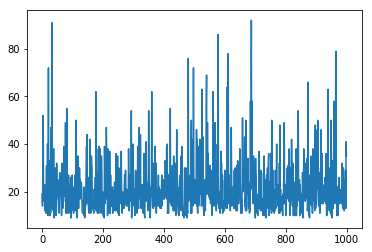

In [7]:
plt.plot(R0)

Let's create the REINFORCE agent. We assume that the policy is computed using an MLP with a softmax output.

In [8]:
'''
Input - Observations (1x4)
Output - Policy (1x2)
'''
class MLP(Chain):
    """Multilayer perceptron"""

    def __init__(self, n_output=1, n_hidden=5):
        super(MLP, self).__init__(l1=L.Linear(None, n_hidden), 
                                  l2=L.Linear(n_hidden, n_output))

    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

1: A skeleton for the REINFORCEAgent is given. Implement the compute_loss and compute_score functions. 

# To Figure out

1. How the Agent and Model interact with each other. 
2. How state (s), action (a), policy (pi) work in this context with the NN
3. What is 'compute_loss'
4. What is 'compute_score'
5. What will be the loss function here - How it would maximize reward (refer slides)

Maximize expected return - using Gradient Ascent


# Questions

1. Do we use both Policy and Value gradient for 'compute_loss'?
2. What is that E function in slides 15 (expected return)
3. Is the (X) equn. in my book correctly correspond to V_t in 'compute_loss'
4. what is V_t?
5. How to maximize Reward?

In [9]:
class REINFORCEAgent(object):
    """Agent trained using REINFORCE"""

    def __init__(self, action_space, model, optimizer=Adam()):

        self.action_space = action_space

        self.model = model

        self.optimizer = optimizer
        self.optimizer.setup(self.model)

        # monitor score and reward
        self.rewards = []
        self.scores = []


    def act(self, observation, reward, done):

        # linear outputs reflecting the log action probabilities and the value
        policy = self.model(Variable(np.atleast_2d(np.asarray(observation, 'float32'))))
#         print('---\nobs', Variable(np.atleast_2d(np.asarray(observation, 'float32'))))
#         print('policy', policy)
        

        # generate action according to policy
        p = F.softmax(policy).data
#         print('p before',p, end=' ')
        # normalize p in case tiny floating precision problems occur
        row_sums = p.sum(axis=1)
        
        p /= row_sums[:, np.newaxis]
#         print('choose policy', p.shape[1], 'prob', p[0])
                                             # a, size=None, replace=True, p=None
        action = np.asarray([np.random.choice(p.shape[1], None, True, p[0])])
#         print('action', action)
#         print('policy', policy)
        return action, policy


    def compute_loss(self):
        """
        Return loss for this episode based on computed scores and accumulated rewards
        
        # loss: compute_score(pi) * R(t)
        
        """
#         print(type(self.scores))
        score = sum(self.scores)
        rw = sum(self.rewards)
#         print(type(score))
#         print(type(rw))
        
        loss = score*rw
#         print(type(LS))
        
#         loss = np.sum(np.array(self.scores))*np.sum(np.array(self.rewards))
#         print(' LOSS ',loss, 'Reward', rw, end=' ')
#         self.rewards = [0]
#         self.scores = [0]
        return loss #Variable(np.array([0]))

    def compute_score(self, action, policy):
        """
        Computes score
        
        # compute score : log pi_theta (s_t, a_t)

        Args:
            action (int):
            policy [pi_theta]:

        Returns:
            score
        """
        p = F.softmax(policy).data
        score = F.log(np.array([p[0][action[0]]]))
#         print('action', action[0], 'policy', p[0], 'score', score)
        return score

# compute_score

$$ \nabla_{\theta} log \pi_{\theta}(s_t, a_t)\cdot v_t $$

Now we run the REINFORCE agent on the CartPole environment. Note that we update the agent after each episode for simplicity.

In [10]:
env = gym.make(env_id)
env.seed(0)

print(env.action_space.n)

network = MLP(n_output=env.action_space.n, n_hidden=3)
agent = REINFORCEAgent(env.action_space, network, optimizer=Adam())

episode_count = 10000
done = False
reward = 0

R = np.zeros(episode_count)

INFO: Making new env: CartPole-v0
2


In [15]:

for i in tqdm.trange(episode_count):

    ob = env.reset()

    loss = 0
#     print('eps' , i, ' ', end=' ')
    while True:

        action, policy = agent.act(ob, reward, done)

        ob, reward, done, _ = env.step(action[0])
#         print('r type', type(reward))
        # get reward associated with taking the previous action in the previous state
        agent.rewards.append(reward)
        R[i] += reward

        # recompute score function: grad_theta log pi_theta (s_t, a_t) * v_t
        agent.scores.append(agent.compute_score(action, policy))
#         print('s type', type(agent.compute_score(action, policy)))
        # we learn at the end of each episode
        if done:
            
            loss += agent.compute_loss()
#             print(' Acc R:', R[i])
            agent.model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            agent.optimizer.update()
            
            agent.rewards = [0]
            agent.scores = [0]

            break

100%|██████████| 10000/10000 [02:10<00:00, 76.57it/s]


In [12]:
# plt.plot(R)

In [13]:
# You may want to run a video of the trained agent performing in the environment using the env.render() function.

# for i in range(3):

#     ob = env.reset()

#     while True:

#         action, policy = agent.act(ob, reward, done)

#         ob, reward, done, _ = env.step(action[0])

#         if done:
#             break
      
#         env.render()

2: Plot the cumulative reward for both RandomAgent and REINFORCEAgent.

(0, 200)

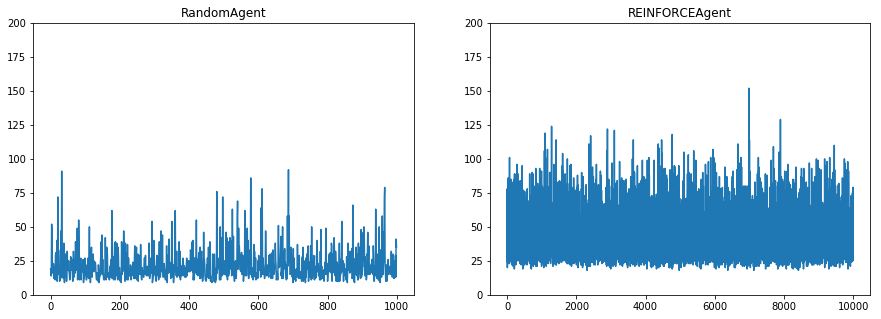

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(R0)
plt.title('RandomAgent')
plt.ylim((0, 200))

plt.subplot(122)
plt.plot(R)
plt.title('REINFORCEAgent')
plt.ylim((0, 200))